# Boosting

На примерах урока мы увидели, что алгоритм XGBoost работает лучше и быстрее относительно GradientBoosting и AdaBoost. Поэтому в этом домашнем задании предлагаем посмотреть, какие еще интересные методы существуют в библиотеке для реализацией этого алгоритма.

### Важность признаков

Признаки, которые используют для обучения модели, оказывают большое влияние на ее качество. Неинформативные или слабо информативные признаки могут существенно понизить эффективность модели.

Отбор признаков – процесс выбора признаков, имеющих наиболее тесные взаимосвязи с целевой переменной. Он позволяет:
- уменьшить переобучение: чем меньше избыточных данных, тем меньше возможностей для модели принимать решения на основе «шума»
- повысить точность: чем меньше противоречивых данных, тем выше точность
- сократить время обучения: чем меньше данных, тем быстрее обучается модель

В библиотеке sckit-learn есть раздел feature_selection, который помогает автоматизировать этот процесс на основе методов статистики, линейной алгебры и некоторых специальных алгоритмов, таких как уже знакомый нам PCA - метод главных компонент.

Некоторые из таких методов реализованы в библиотеках для конкретных алгоритмов, к которым относится и xgboost.

Сгенерируем синтетические данные. 

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

x, y = make_classification(n_samples=1000, n_features=15, n_informative=7, 
                           n_redundant=3, n_repeated=3, random_state=17)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)

features = pd.DataFrame(x)
targets = pd.Series(y)

scat_mrtx = pd.plotting.scatter_matrix(features, c=targets, figsize=(25, 25), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Теперь приступим к построению модели. В уроке мы разбирали алгоритм xgboost в интерфейсе библиотеки sklearn: для обучения использовали метод *fit* модели, а для предсказаний - *predict*.

Здесь будем использовать интерфейс библиотеки xgboost.

В этом интерфейсе для обучения XGBoost данные должны быть представлены в виде объекта DMatrix - внутренней структуры данных, используемой библиотекой  XGBoost, которая оптимизирована как по эффективности работы с памятью, так и по скорости обучения.

Также заранее определим параметры алгоритма:
- бинарная классификация - 'objective': 'binary:logistic'
- глубина деревьев - 'max_depth': 3
- шаг градиентного спуска (скорость обучения) - 'eta': 0.1
- количество итераций бустинга - num_rounds = 60

In [2]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

### 1.
С помощью метода *train* библиотеки xgboost обучите модель. Передайте в метод вышеопределенные словарь параметров, тренировочные данные в формате DMatrix и число итераций.

In [3]:
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds)

[21:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 2.
В методе *train* есть параметр *evals* - список валидационных наборов данных, для которых будут оцениваться показатели во время обучения. Они помогут нам отслеживать качество модели для каждой итерации.

Создайте список из двух кортежей (dtest, 'test') и (dtrain, 'train'). Снова определите метод train аналогично предыдущему пункту, добавив этот список в качестве параметра.

In [4]:
evals = [(dtest, 'test'), (dtrain, 'train')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=evals)

[21:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.66343	train-logloss:0.65325
[1]	test-logloss:0.63855	train-logloss:0.62012
[2]	test-logloss:0.61802	train-logloss:0.59225
[3]	test-logloss:0.59999	train-logloss:0.56655
[4]	test-logloss:0.58840	train-logloss:0.54443
[5]	test-logloss:0.57064	train-logloss:0.52526
[6]	test-logloss:0.55664	train-logloss:0.50836
[7]	test-logloss:0.54734	train-logloss:0.49023
[8]	test-logloss:0.53869	train-logloss:0.47380
[9]	test-logloss:0.53187	train-logloss:0.45862
[10]	test-logloss:0.51961	train-logloss:0.44627
[11]	test-logloss:0.51053	train-logloss:0.43366
[12]	test-logloss:0.50065	train-logloss:0.42058
[13]	test-logloss:0.49537	train-logloss:0.40988
[14]	test-logloss:0.48768	tr

### 3.
В качестве метрики оценки важности признаков в XGBoost используется F-score, которая вычисляется на основе того, как часто делалось разбиение по данному признаку.

Используйте метод plot_importance библиотеки XGBoost. Передайте туда в качестве параметра xgb_model.

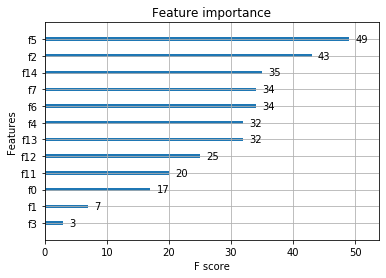

In [5]:
xgb.plot_importance(xgb_model)

По полученным данным можно посмотреть, какие признаки являются излишними и их можно убрать, а какие наиболее важны при обучении модели, т.е. используются чаще всего.

### Несбалансированные выборки

Мы уже упоминали о том, что работа с несбалансированными выборками несколько отличается от работы с идеальными датасетами. В XGBoost есть возможность несколько упростить эту работу: 
- задать большие веса некоторым объектам при инициализации DMatrix
- контролировать соотношение числа объектов разных классов с помощью параметра set_pos_weight

Сгенерируем несбалансированную выборку.

In [6]:
x, y = make_classification(n_samples=1000, n_features=7, n_informative=3, n_redundant=3, 
                           n_classes=2, weights=[.9, .1], random_state=20)

print(f'There are {sum(y)} positive instances')

There are 104 positive instances


### 4.
Разбейте выборку на тренировочную и тестовую, соблюдая стратификацию по *y* и размер тестового датасета 0.3. Создайте объекты DMatrix для тренировочной и тестовой выборок.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

Зададим параметры для алгоритма и количество итераций.

In [9]:
params = {'objective': 'binary:logistic', 
          'max_depth': 1, 
          'silent': 1, 
          'eta': 1}

num_rounds = 30

### 5.
С помощью метода train обучите модель. С помощью метода predict получите предсказания для тестовых данных. Так как алгоритм возвращает вероятности, получите бинарную матрицу значений этих вероятностей, элементы которой при полученной вероятности > 0.5 равны True, а при вероятности <= 0.5 равны False. Выведите эту матрицу.

In [12]:
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds)
xgb_model_predict = xgb_model.predict(dtest)
predictions = [round(value) for value in xgb_model_predict]
print(predictions)

[21:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

### 6.
Выведите матрицу ошибок, точность и полноту для полученных предсказаний.

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [21]:
conf_mtrx = confusion_matrix(y_test, predictions)
print(f'Матрица ошибок:\n {conf_mtrx}')
precision = precision_score(y_test, predictions)
print(f'Точность: {precision}')
recall = recall_score(y_test, predictions)
print(f'Полнота: {recall}')

Матрица ошибок:
 [[262   7]
 [ 16  15]]
Точность: 0.6818181818181818
Полнота: 0.4838709677419355


Видно, что полнота гораздо ниже точности, т.е. алгоритм плохо распознает объекты класса, который представлен меньшим количеством экземпляров.

Теперь зададим вручную веса для экземпляров классов.

In [28]:
import numpy as np

weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

### 7.
Повторите то же, что делали ранее: создайте объекты DMatrix - для тренировочных данных укажите веса, а для тестовых оставьте только сами данные; обучите модель и получите ее предсказания так же, как и в предыдущем случае. Выведите матрицу ошибок, точность и полноту.

In [29]:
dtrain = xgb.DMatrix(data=x_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(x_test, y_test)

xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds)
xgb_model_predict = xgb_model.predict(dtest)
predictions = [round(value) for value in xgb_model_predict]
conf_mtrx = confusion_matrix(y_test, predictions)
print(f'Матрица ошибок:\n {conf_mtrx}')
precision = precision_score(y_test, predictions)
print(f'Точность: {precision}')
recall = recall_score(y_test, predictions)
print(f'Полнота: {recall}')

[21:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Матрица ошибок:
 [[254  15]
 [  8  23]]
Точность: 0.6052631578947368
Полнота: 0.7419354838709677


Можем увидеть, что значение полноты увеличилось, но при этом точность уменьшилась. Если нам важны обе метрики, то пригодится параметр scale_pos_weight в XGBoost.

### 8.
Снова создайте объекты DMatrix, как в первом случае (без задания весов).

In [30]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)


### 9.
Инициализируйте параметр scale_pos_weight как соотношение числа объектов двух классов. Для этого число объектов класса 0 разделите на число объектов класса 1. Добавьте в словарь параметров алгоритма params пару с ключом 'scale_pos_weight' и значением, равным полученному соотношению классов.

In [32]:
count_0 = 0
count_1 = 0
for i in y:
    if i == 0:
        count_0 += 1
    if i == 1:
        count_1 += 1
scale_pos_weight = count_0 / count_1
params = {'objective': 'binary:logistic', 
          'max_depth': 1, 
          'silent': 1, 
          'eta': 1,
          'scale_pos_weight': scale_pos_weight}


### 10.
Обучите модель с параметрами params и получите ее предсказания для тестовой выборки. Выведите матрицу ошибок, точность и полноту.**

In [33]:

xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds)
xgb_model_predict = xgb_model.predict(dtest)
predictions = [round(value) for value in xgb_model_predict]
conf_mtrx = confusion_matrix(y_test, predictions)
print(f'Матрица ошибок:\n {conf_mtrx}')
precision = precision_score(y_test, predictions)
print(f'Точность: {precision}')
recall = recall_score(y_test, predictions)
print(f'Полнота: {recall}')

[21:58:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:58:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Матрица ошибок:
 [[239  30]
 [  6  25]]
Точность: 0.45454545454545453
Полнота: 0.8064516129032258


Значение параметра scale_pos_weight надо выбирать в зависимости от желаемого соотношения между точностью и полнотой. Например, если нам нужны примерно одинаковые значения precision и recall, в данном случае следует уменьшить полученное значение параметра в несколько раз.